In [1]:
import torch
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import socketio
import queue
import threading
import os
import json
from numba import jit, prange
from numba.typed import List
from points import Point
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
import tensorflow as tf
from tensorflow import keras
import seaborn as sns


# Interactive Hologram

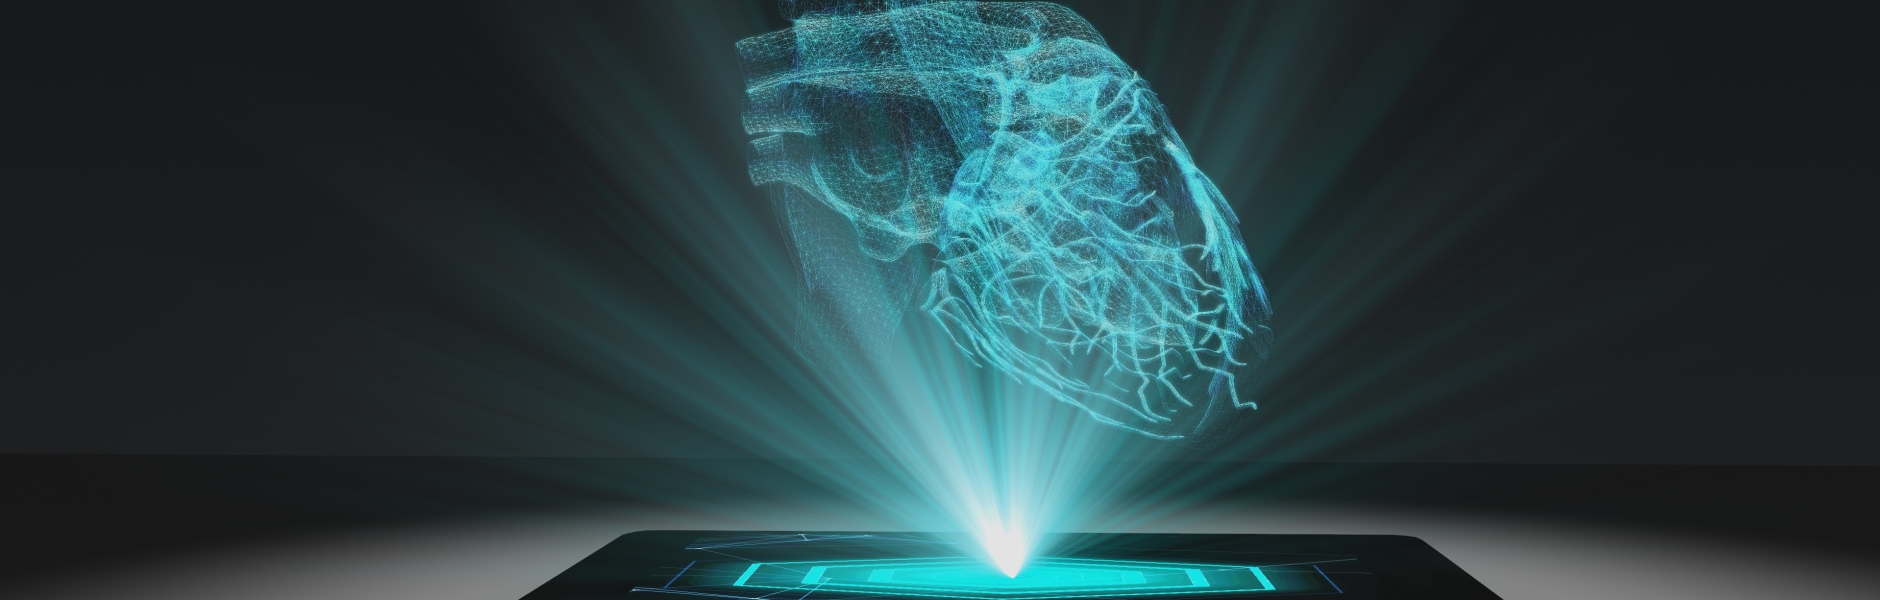

Holograms have been a dream of tech and entertainment companies as well as consumers ever since a long time. The real hologram can be seen without the aid of any special lenses,screens or props. But there are holographic images produced by means of lenses to create stage illusions like Pepper’s Ghost which are not true holograms, they are called holographic illusions. We will be using Pepper’s Ghost Pyramid to create our holographic illusion.

The DIY hologram pyramid is a simple device that can be made by manipulating a sheet of plastic into the shape of a pyramid with its top cut off. The device creates a 3D-like illusion for the viewer and makes an image or video appear as if it were in midair.

### Objective

The objective of the project is to make use of the key points of the hand generated by the SRHandNET model to create a new model which will recognise the hand gestures from the key points. Using these gestures we will assign different actions to the which will be used to manipulate the 3D objects in our hologram. 

# Stage 1 (SRHandNet)

- Gesture recognition for human computer interaction is an area of active research in computer vision and machine learning.
- The primary goal of gesture recognition research is to create a system, which can identify specific human gestures and use them to convey information or for device control.
- These gestures may either be still or moving.

### SRHandNET is a machine learning model for real-time 2D hand pose estimation. 

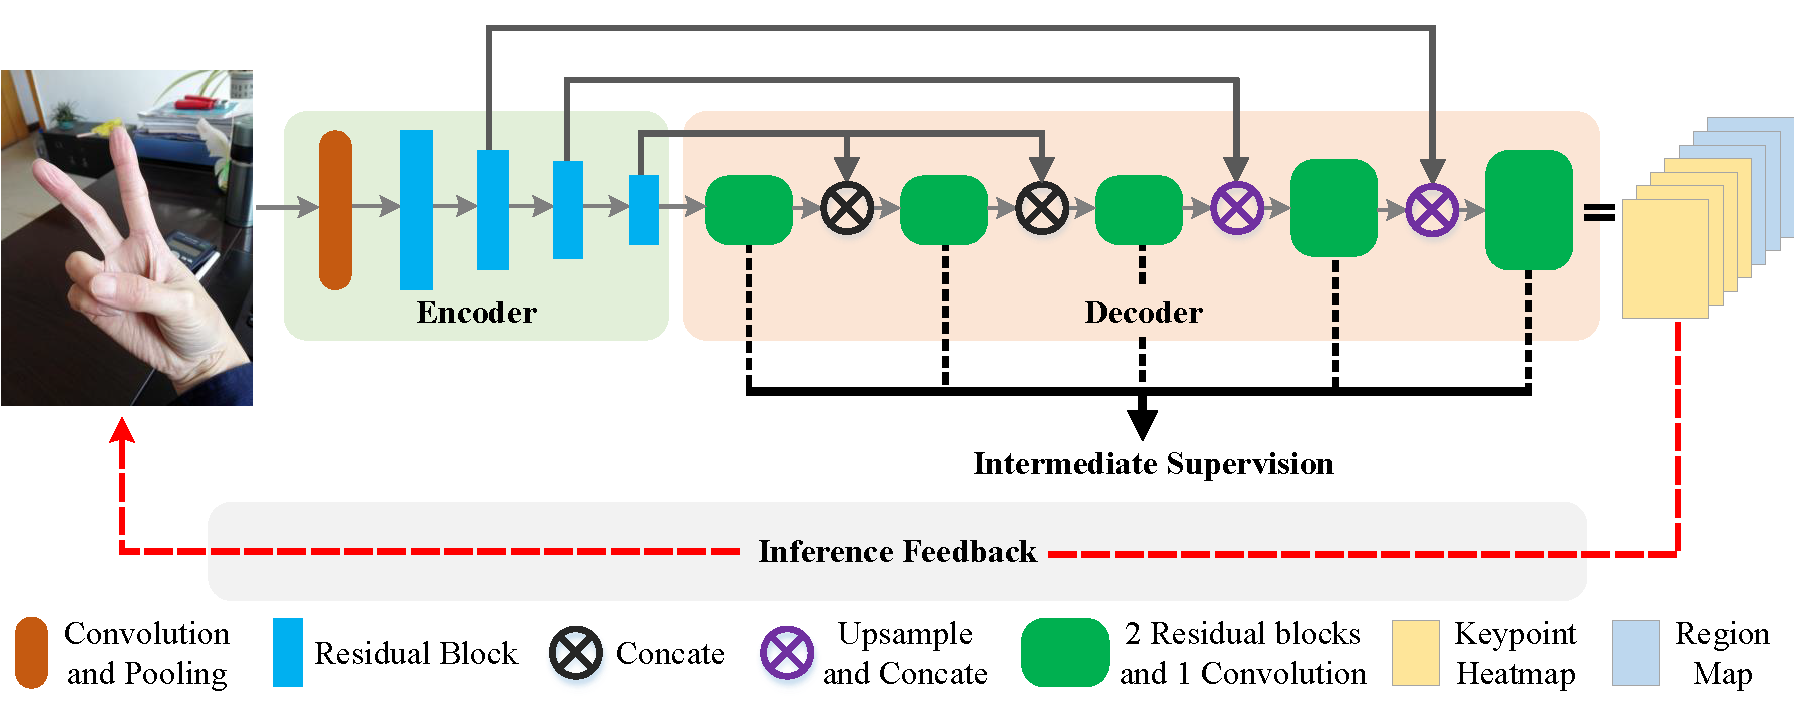

IEEE Paper: https://ieeexplore.ieee.org/document/8917796

---

The authors of SRHandNet used PyTorch in C++ to train their model and make predictions. The trained PyTorch model and the C++ code required to apply it was open sourced by them and is available here: https://www.yangangwang.com/papers/WANG-SRH-2019-07.html

-------

As we were unable to find necessary libraries required for seamless interfacing of C++ and Python, we converted their source code for hand pose detection to Python: <b>line by line</b>

Following is the code for Stage 1 with several adjustments of our own for further use and acceleration by Numba

In [2]:
# colors for 21 points on the hand
HAND_POINT_COLORS = [
    (100, 100, 100), (100, 0, 0), (150, 0, 0), (200, 0, 0), (255, 0, 0),
    (100, 100, 0), (150, 150, 0), (200, 200, 0), (255, 255, 0), (0, 100, 50),
    (0, 150, 75), (0, 200, 100), (0, 255, 125), (0, 50, 100), (0, 75, 150),
    (0, 100, 200), (0, 125, 255), (100, 0, 100), (150, 0, 150), (200, 0, 200),
    (255, 0, 255),
]
TRAIN_IMAGE_HEIGHT = 256
TRAIN_IMAGE_WIDTH = 256

#### `is_local_value_great` merely scans through a given block to check if any individual value is greater
Separated from get_locations for numba optimization

In [3]:
@jit(nopython=True, cache=True)
def is_local_value_great(src, locval, temploc):
    blockwidth=2
    startout = max(temploc[0] - blockwidth, 0)
    endout = min(temploc[0] + blockwidth, src.shape[1] - 1) + 1
    startin = max(temploc[1] - blockwidth, 0)
    endin = min(temploc[1] + blockwidth, src.shape[0] - 1) + 1
    
    for m in prange(startout, endout):
        for n in prange(startin, endin):
            if float(src[n, m]) > locval:
                return False
    return True

#### `get_locations` scans through matrix and returns points of interest (ie confidence greater than thresholds)
numba parallelizes the search

In [4]:
@jit(nopython=True, parallel=True, cache=True)
def get_locations(src, threshold):
    location = List()
    blockwidth=2

    endout = src.shape[1] - blockwidth
    endin = src.shape[0] - blockwidth
    
    for i in prange(blockwidth, endout):
        for j in prange(blockwidth, endin):
            tmploc = (i, j)
            localvalue = float(src[j, i])
            
            if localvalue < threshold:
                continue
                
            localmaximum = is_local_value_great(src, localvalue, tmploc)
            
            if localmaximum:
                location.append((localvalue, np.array(tmploc)))
                
    return location

#### `transform_input` transforms the input of any dimenstion to specific dimensions

In [5]:
@jit(cache=True, forceobj=True, nopython=True)
def transform_input(input_tensor, src_img, tensor_index=0):
    ratio = min(
        input_tensor.shape[2] / src_img.shape[0],
        input_tensor.shape[3] / src_img.shape[1]
    )
    M = np.float32([[ratio, 0, 0], [0, ratio, 0]])
    dst = cv2.warpAffine(src_img, M, (input_tensor.size(3), input_tensor.size(2)), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=128)
    
    dst = dst / 255.0 - 0.5
    chn_img = cv2.split(dst)
    
    if len(chn_img) == 1:
        input_tensor[tensor_index][0] = torch.from_numpy(chn_img[0])
        input_tensor[tensor_index][1] = torch.from_numpy(chn_img[0])
        input_tensor[tensor_index][2] = torch.from_numpy(chn_img[0])
    else:
        input_tensor[tensor_index][0] = torch.from_numpy(chn_img[0])
        input_tensor[tensor_index][1] = torch.from_numpy(chn_img[1])
        input_tensor[tensor_index][2] = torch.from_numpy(chn_img[2])
    return ratio

#### `detectBbox` finds the bounding box for the hand(s)

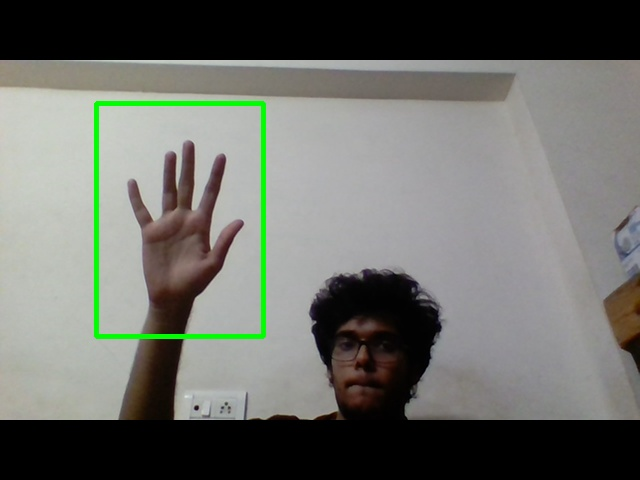

In [6]:
def detect_bounding_box(boxes, model, input_image):
    input_tensor = torch.zeros(1, 3, TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH)
    
    ratio_input_to_net = transform_input(input_tensor, input_image)
    
    heatmap = model.forward(input_tensor.cuda())[3]
    ratio_net_downsample = TRAIN_IMAGE_HEIGHT / heatmap.size(2)
    rect_map_idx = heatmap.size(1) - 3
    rectmap = [None] * 3
    
    for i in range(3):
        rectmap[i] = heatmap[0][i + rect_map_idx].cpu().detach().numpy()
    
    locations = get_locations(rectmap[0], HAND_THRESHOLD)

    boxes.clear()
    
    for i in locations:
        points = i[1]
        pos_x = points[0]
        pos_y = points[1]
        
        ratio_width = 0.0
        ratio_height = 0.0
        pixelcount = 0
        
        for m in range(max(pos_y - 2, 0), min(pos_y + 3, heatmap.size(2))):
            for n in range(max(pos_x - 2, 0), min(pos_x + 3, heatmap.size(3))):
                ratio_width += float(rectmap[1][m, n])
                ratio_height += float(rectmap[2][m, n])
                pixelcount += 1
                
        if pixelcount > 0:
            ratio_width = min(max(ratio_width/pixelcount, 0.0), 1.0)
            ratio_height = min(max(ratio_height/pixelcount, 0.0), 1.0)
            
            points = points * ratio_net_downsample / ratio_input_to_net
            rect_w = ratio_width * TRAIN_IMAGE_WIDTH / ratio_input_to_net
            rect_h = ratio_height * TRAIN_IMAGE_HEIGHT / ratio_input_to_net
            
            lt = (points - np.array([rect_w//2, rect_h//2])).astype('int32')
            rb = (points + np.array([rect_w//2, rect_h//2])).astype('int32')
            lt[0] = max(lt[0], 0)
            lt[1] = max(lt[1], 0)
            rb[0] = min(rb[0], input_image.shape[1]-1)
            rb[1] = min(rb[1], input_image.shape[0]-1)
            boxes.append((lt[0], lt[1], rb[0]-lt[0], rb[1]-lt[1]))

#### `detecthand` finds individual key-points inside the boundary box

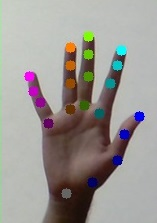

In [7]:
def detect_hand_points(manypoints, model, input_image, boxes, locs, rects):
    input_tensor = torch.zeros(len(boxes), 3, TRAIN_IMAGE_HEIGHT, TRAIN_IMAGE_WIDTH)
    ratio_input_to_net = [None]*len(boxes)
    for i in range(len(boxes)):
        a = int(boxes[i][0])
        b = a + int(boxes[i][2])
        c = int(boxes[i][1])
        d = c + int(boxes[i][3])
        sliced = input_image[c:d, a:b]
        ratio_input_to_net[i] = transform_input(input_tensor, sliced, i)
    
    net_result = model.forward(input_tensor.cuda())[3]
    ratio_net_downsample = TRAIN_IMAGE_HEIGHT / net_result.size(2)
    
    if len(boxes) == 2:
        rects.clear()
    
    for rect_idx in range(len(boxes)):
        rect = []
        for i in range(net_result.size(1) - 3):
            heatmap = net_result[rect_idx][i].cpu().detach().numpy()
            pts = get_locations(heatmap, FINGER_THRESHOLD)

            count = 0
            for j in pts:
                if count >= 1:
                    break
                temp = j[1]
                
                if count == 0:
                    locs[i] = j[1].copy()
                
                temp = temp*ratio_net_downsample/ratio_input_to_net[rect_idx]
                temp = temp + np.array([boxes[rect_idx][0], boxes[rect_idx][1]])
                manypoints[i].append((j[0], temp))
                rect.append(temp.copy())
                count += 1
                
        rects.append(rect)

#### `detect_box_and_hand` accepts trained model and input_image, plots the points on it  and returns
- locations with respect to 64 x 64 square (input for Stage 2)
- list of hands and points
- center of the detection

In [8]:
@jit(forceobj=True)
def detect_box_and_hand(model, input_image):
    center = np.array([0, 0])
    rects = []
    boxes = []
    locs = [None]*21

    many_keypoints = [[] for _ in range(21)]

    boxes.append((0, 0, input_image.shape[1], input_image.shape[0]))
    detect_bounding_box(boxes, model, input_image)

    if len(boxes) == 0:
        return (locs, [], None)

    thickness_circle_ratio = 1 / 120
    thickness_circle = max(int(math.sqrt(input_image.shape[1] * input_image.shape[0]) * thickness_circle_ratio + 0.5), 2)
    number_colors = len(HAND_POINT_COLORS)
    
    detect_hand_points(many_keypoints, model, input_image, boxes, locs, rects)
    count = 0
    for curr_joint_index in range(0, 21):
        curr_color = HAND_POINT_COLORS[curr_joint_index % number_colors]
        
        for i in many_keypoints[curr_joint_index]:
            center = center + i[1]
            count += 1
            cv2.circle(input_image, (int(i[1][0]), int(i[1][1])), thickness_circle, curr_color, -1)
#             cv2.putText(input_image, str(curr_joint_index), (int(i[1][0]), int(i[1][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0, 0, 255), 1)
    
    if count != 0:
        center = center / count
#         cv2.circle(input_image, (int(centers[0]), int(centers[1])), thickness_circle, (0, 0, 0), -1)
        
    for i in boxes:
        cv2.rectangle(input_image, i, (0, 255, 0), thickness=int(min(input_image.shape[1] / TRAIN_IMAGE_WIDTH * 3.0, 3.0)))

    return (locs, rects, center)

In [9]:
def clean_points(points):
    temp = [20, 16, 12, 8, 17, 13, 9, 5]
    for i in range(len(temp)):
        if points[temp[i]] is None:
            points[temp[i]] = points[temp[(i+4)%8]]

#### Loading PyTorch model to CUDA
CUDA is a parallel computing platform and application programming interface model created by Nvidia. It allows software developers and software engineers to use a CUDA-enabled graphics processing unit for general purpose processing – an approach termed GPGPU.

Current machine supports CUDA

In [10]:
model_1 = torch.jit.load('hand.pts', map_location=torch.device('cuda'))

### Main loop for Stage 1
(not part of the final program)

Outputs a video feed with highlighted bounding box and keypoints

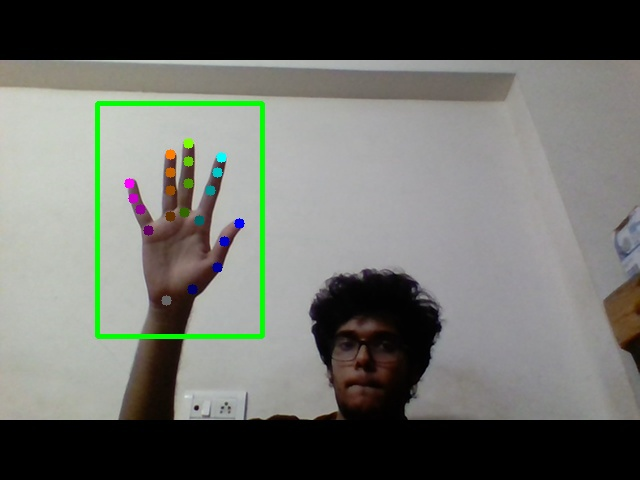

In [11]:

HAND_THRESHOLD = 0.8
FINGER_THRESHOLD = 0.2

capture = cv2.VideoCapture(0)

while True:

    ret, frame = capture.read()
    
    if frame is None:
        print("Cannot open camera")
        cv2.destroyAllWindows()
        break

    t = cv2.getTickCount()

    try:
        points, rects, center  = detect_box_and_hand(model_1, frame)
    except OverflowError:
        print('overflow error')
        continue
        
    no_of_pts = len([i for i in points if i is not None])


    t = (cv2.getTickCount() - t) / cv2.getTickFrequency()
    fps = 1.0 / t
    
    cv2.putText(frame, "FPS: {}".format(round(fps, 2)), (frame.shape[1] - 200, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(frame, "PTS: {}".format(no_of_pts), (frame.shape[1] - 200, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow('hand detection', frame)
    
    
    if cv2.waitKey(1) == 27:
        cv2.destroyAllWindows()
        break

capture.release()
cv2.destroyAllWindows()


### Stage 1 has found the keypoints required for Stage 2

Plotting the points received from stage 2

(64, 0)

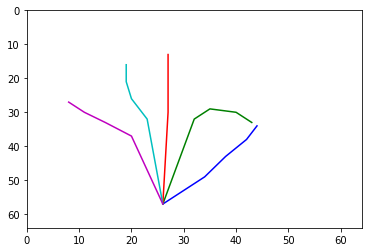

In [12]:
lines = [
    [0, 1, 2, 3, 4],
    [0, 5, 6, 7, 8],
    [0, 9, 10, 11, 12],
    [0, 13, 14, 15, 16],
    [0, 17, 18, 19, 20],
]
cols = 'bgrcm'
points = np.array(points)
for i in range(len(lines)):
    plt.plot(points[lines[i]][:, 0], points[lines[i]][:, 1], '-{}'.format(cols[i%5]))
plt.xlim([0, 64])
plt.ylim([64, 0])

# Stage 2 (Artificial Neural Network for Classification of Spatial Data)

## Generation of Data for Stage 2

To generate such data for the following classes, we wrote a script that allowed us to generate datapoints at the rate of 4 images per second.

labels = [
    '1_finger',
    '2_finger',
    '3_finger',
    '4_finger',
    '5_finger',
    'okay',
    'thumbs_up',
    'thumbs_down',
    'call',
]

## Generate Dataset

- set the label
- press `s` to add the image to dataset
    - the selected frame as well as mirror image of it will be passed through model1 and spatial output data will be stored
    - if the hand in the image does not contain 21 datapoints, it'll be rejected
- press `q` when you're done
- run the cell after the cell below to save or append the data to `{label}.json`


- for collecting fresh data ensure folder of label and `{label}.json` are deleted

In [13]:
%matplotlib qt

cam = cv2.VideoCapture(0)

cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1280);
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 960);

label = 'label'
points = []
fig, axs = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(4)
plt.ion()
HAND_THRESHOLD = 0.8
FINGER_THRESHOLD = 0.2

try:
    ct = max([int(i.split('.')[0]) for i in next(os.walk(label))[2]])+1
except Exception:
    os.makedirs(label, exist_ok=True)
    ct = 1

# for loop that iterates through images can also be used, make necessary changes
while True:    
    _, img = cam.read()
    
    bounds = (0, 0, 300, 300)
    cv2.rectangle(img, bounds, (255, 255, 255), 1)
    
    cv2.imshow('camera', img)
    cv2.imshow('frame', img[bounds[1]:bounds[1]+bounds[3], bounds[0]:bounds[0]+bounds[2]])
    
    key = cv2.waitKey(1) & 0xff
    
    if key == ord('s'):
        cropped1 = img[bounds[1]:bounds[1]+bounds[3], bounds[0]:bounds[0]+bounds[2]].copy()
        cropped2 = cv2.flip(cropped1, 1)
        
        cropped1_ = cropped1.copy()
        cropped2_ = cropped2.copy()
        
        l1 = [None]*21
        l2 = [None]*21
        pyramidinference(model, cropped1_, [], l1, [])
        pyramidinference(model, cropped2_, [], l2, [])
        clean_pts(l1)
        clean_pts(l2)
        
        if None not in l1:
            cv2.imshow('capture1', cropped1_)
            cv2.imwrite('{}\\{}.jpg'.format(label, ct), cropped1)
            points.append((ct, l1.copy()))
            c1 = Point.conv_np(points[-1][1])
            for i in range(len(lines)):
                axs[0].plot(c1[lines[i]][:, 0], c1[lines[i]][:, 1], '-{}'.format(cols[i%5]))
            axs[0].set_title(f"{ct}-right.jpg")
            axs[0].set_xlim([0, 64])
            axs[0].set_ylim([64, 0])

            cv2.destroyWindow('None1')
            ct += 1
        else:
            cv2.imshow('None1', cropped1_)
            cv2.destroyWindow('capture1')


        if None not in l2:
            cv2.imshow('capture2', cropped2_)
            cv2.imwrite('{}\\{}.jpg'.format(label, ct), cropped2)
            points.append((ct, l2.copy()))       
            c2 = Point.conv_np(points[-1][1])
            for i in range(len(lines)):
                axs[1].plot(c2[lines[i]][:, 0], c2[lines[i]][:, 1], '-{}'.format(cols[i%5]))
            axs[1].set_title(f"{ct}-left.jpg")
            axs[1].set_xlim([0, 64])
            axs[1].set_ylim([64, 0])
            cv2.destroyWindow('None2')
            ct += 1
        else:
            cv2.imshow('None2', cropped2_)
            cv2.destroyWindow('capture2')

        
        fig.suptitle('Skeletons')
        plt.draw()
    
    if key == ord('q'):
        break
    
cam.release()
plt.close()
cv2.destroyAllWindows()

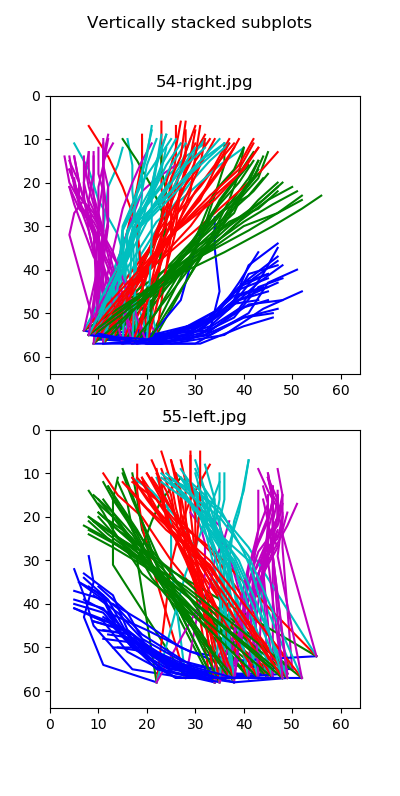

After generating plenty of data, we'll now consolidate it

### List of labels of hand gestures that can be recognised.
Our model can currently recognise 9 gestures. More gestures can be added to the dataset in order to expand the scope of the model.

In [14]:
labels = [
    '1_finger',
    '2_finger',
    '3_finger',
    '4_finger',
    '5_finger',
    'okay',
    'thumbs_up',
    'thumbs_down',
    'call',
]

### Loading the dataset for all the gestures. 
The dataset for each gesture is stored in a .json file. These are all combined into a single dataset which is used to train and test the model.

In [15]:
dataset = []
for i in labels:
    dataset.extend(json.loads(open('data/{}.json'.format(i)).read()))

### Separating into flattened keypoints and label associated with that gesture.


In [16]:
X = []
Y = []
for i in dataset:
    X.append(i['flattened'])
    Y.append(i['label'])

### Count of training images for each gesture.

In [17]:
Counter(Y)

Counter({'1_finger': 702,
         '2_finger': 645,
         '3_finger': 615,
         '4_finger': 628,
         '5_finger': 623,
         'okay': 641,
         'thumbs_up': 542,
         'thumbs_down': 544,
         'call': 539})

In [18]:
X = pd.DataFrame(X)
Y = pd.DataFrame(Y, columns=['labels'])
df = pd.concat([X, Y], axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,labels
0,14,57,22,54,28,46,28,38,25,30,...,44,5,45,5,37,8,42,9,46,1_finger
1,21,57,13,53,6,46,5,38,7,31,...,45,30,43,28,38,26,44,23,47,1_finger
2,14,57,21,55,29,47,30,38,29,31,...,44,6,44,8,35,9,41,10,45,1_finger
3,23,57,14,54,7,47,5,39,6,31,...,44,29,40,27,35,25,41,24,45,1_finger
4,16,57,22,51,28,44,28,36,25,29,...,43,5,44,5,35,8,41,9,44,1_finger


### Splitting the dataset into training and testing sets.

In [19]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.2, random_state=20)
Y_train_ = np.array([labels.index(i[0]) for i in Y_train.values])
Y_test_ = np.array([labels.index(i[0]) for i in Y_test.values])
print(X_train.shape)
print(Y_train_.shape)

(4383, 42)
(4383,)


### Creating the model
Creating a Keras Sequential model for the neural network. Our model can work with a minimum of 2 hidden layers with variable number of neurons (in this case 24 and 16 respectively). The hidden layers are activated using the ELU (Exponential Linear Unit) function which provided greater accuracy than RELU or Sigmoid activation functions.

In [20]:
model = keras.Sequential()
model.add(keras.layers.Dense(24, input_shape=(42,)))
model.add(keras.layers.Dense(16,  activation='elu'))
model.add(keras.layers.Dense(9))

### Summary of the Keras Sequential model
This provides information regarding the type of layers, The output shape of the layer as well as the number of parameters of each layer.

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                1032      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 153       
Total params: 1,585
Trainable params: 1,585
Non-trainable params: 0
_________________________________________________________________


### Compiling the model
`adam` is an adaptive learning rate optimization algorithm that’s been designed specifically for training deep neural networks. `SparseCategoricalCrossentropy` computes the crossentropy loss between the labels and predictions. Keras metrics are functions that are used to evaluate the performance of a deep learning model. Our model uses the 'Accuracy' metric.

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Fitting the model
The model is fitted with the training dataset and observing the change in accuracy with each Epoch.

In [23]:
model.fit(X_train.values, Y_train_, epochs=10)

Train on 4383 samples
Epoch 1/10
4383/4383 [==============================] - 1s 172us/sample - loss: 6.0902 - accuracy: 0.2268
Epoch 2/10
4383/4383 [==============================] - 0s 69us/sample - loss: 1.1989 - accuracy: 0.5857
Epoch 3/10
4383/4383 [==============================] - 0s 83us/sample - loss: 0.7235 - accuracy: 0.7960
Epoch 4/10
4383/4383 [==============================] - 0s 71us/sample - loss: 0.5563 - accuracy: 0.8453
Epoch 5/10
4383/4383 [==============================] - 0s 75us/sample - loss: 0.4555 - accuracy: 0.8802
Epoch 6/10
4383/4383 [==============================] - 0s 68us/sample - loss: 0.3967 - accuracy: 0.9010
Epoch 7/10
4383/4383 [==============================] - 0s 73us/sample - loss: 0.3557 - accuracy: 0.9103
Epoch 8/10
4383/4383 [==============================] - 0s 68us/sample - loss: 0.3286 - accuracy: 0.9167
Epoch 9/10
4383/4383 [==============================] - 0s 69us/sample - loss: 0.3007 - accuracy: 0.9252
Epoch 10/10
4383/4383 [=========

### The loss and the accuracy of the test dataset

In [24]:
test_loss, test_acc = model.evaluate(X_test.values,  Y_test_, verbose=2)

1096/1096 - 0s - loss: 0.3146 - accuracy: 0.9316


### Making predictions using the test data.


In [25]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test.values)

### Each model is saved separatey in order to moniter performance.

In [26]:
model.save('model2_9_3')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model2_9_3\assets


### Creating a confusion matrix using the predictions and the test labels

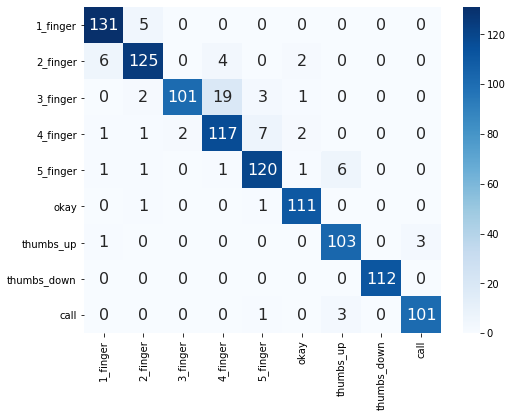

In [29]:
%matplotlib inline
p1 = np.array([np.argmax(i) for i in predictions])
conf_matrix = pd.DataFrame(tf.math.confusion_matrix(Y_test_, p1).numpy(), index=labels, columns=labels)
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(conf_matrix, annot=True, cmap="Blues", annot_kws={"size": 16}, fmt='d')

### Stage 2 is now ready

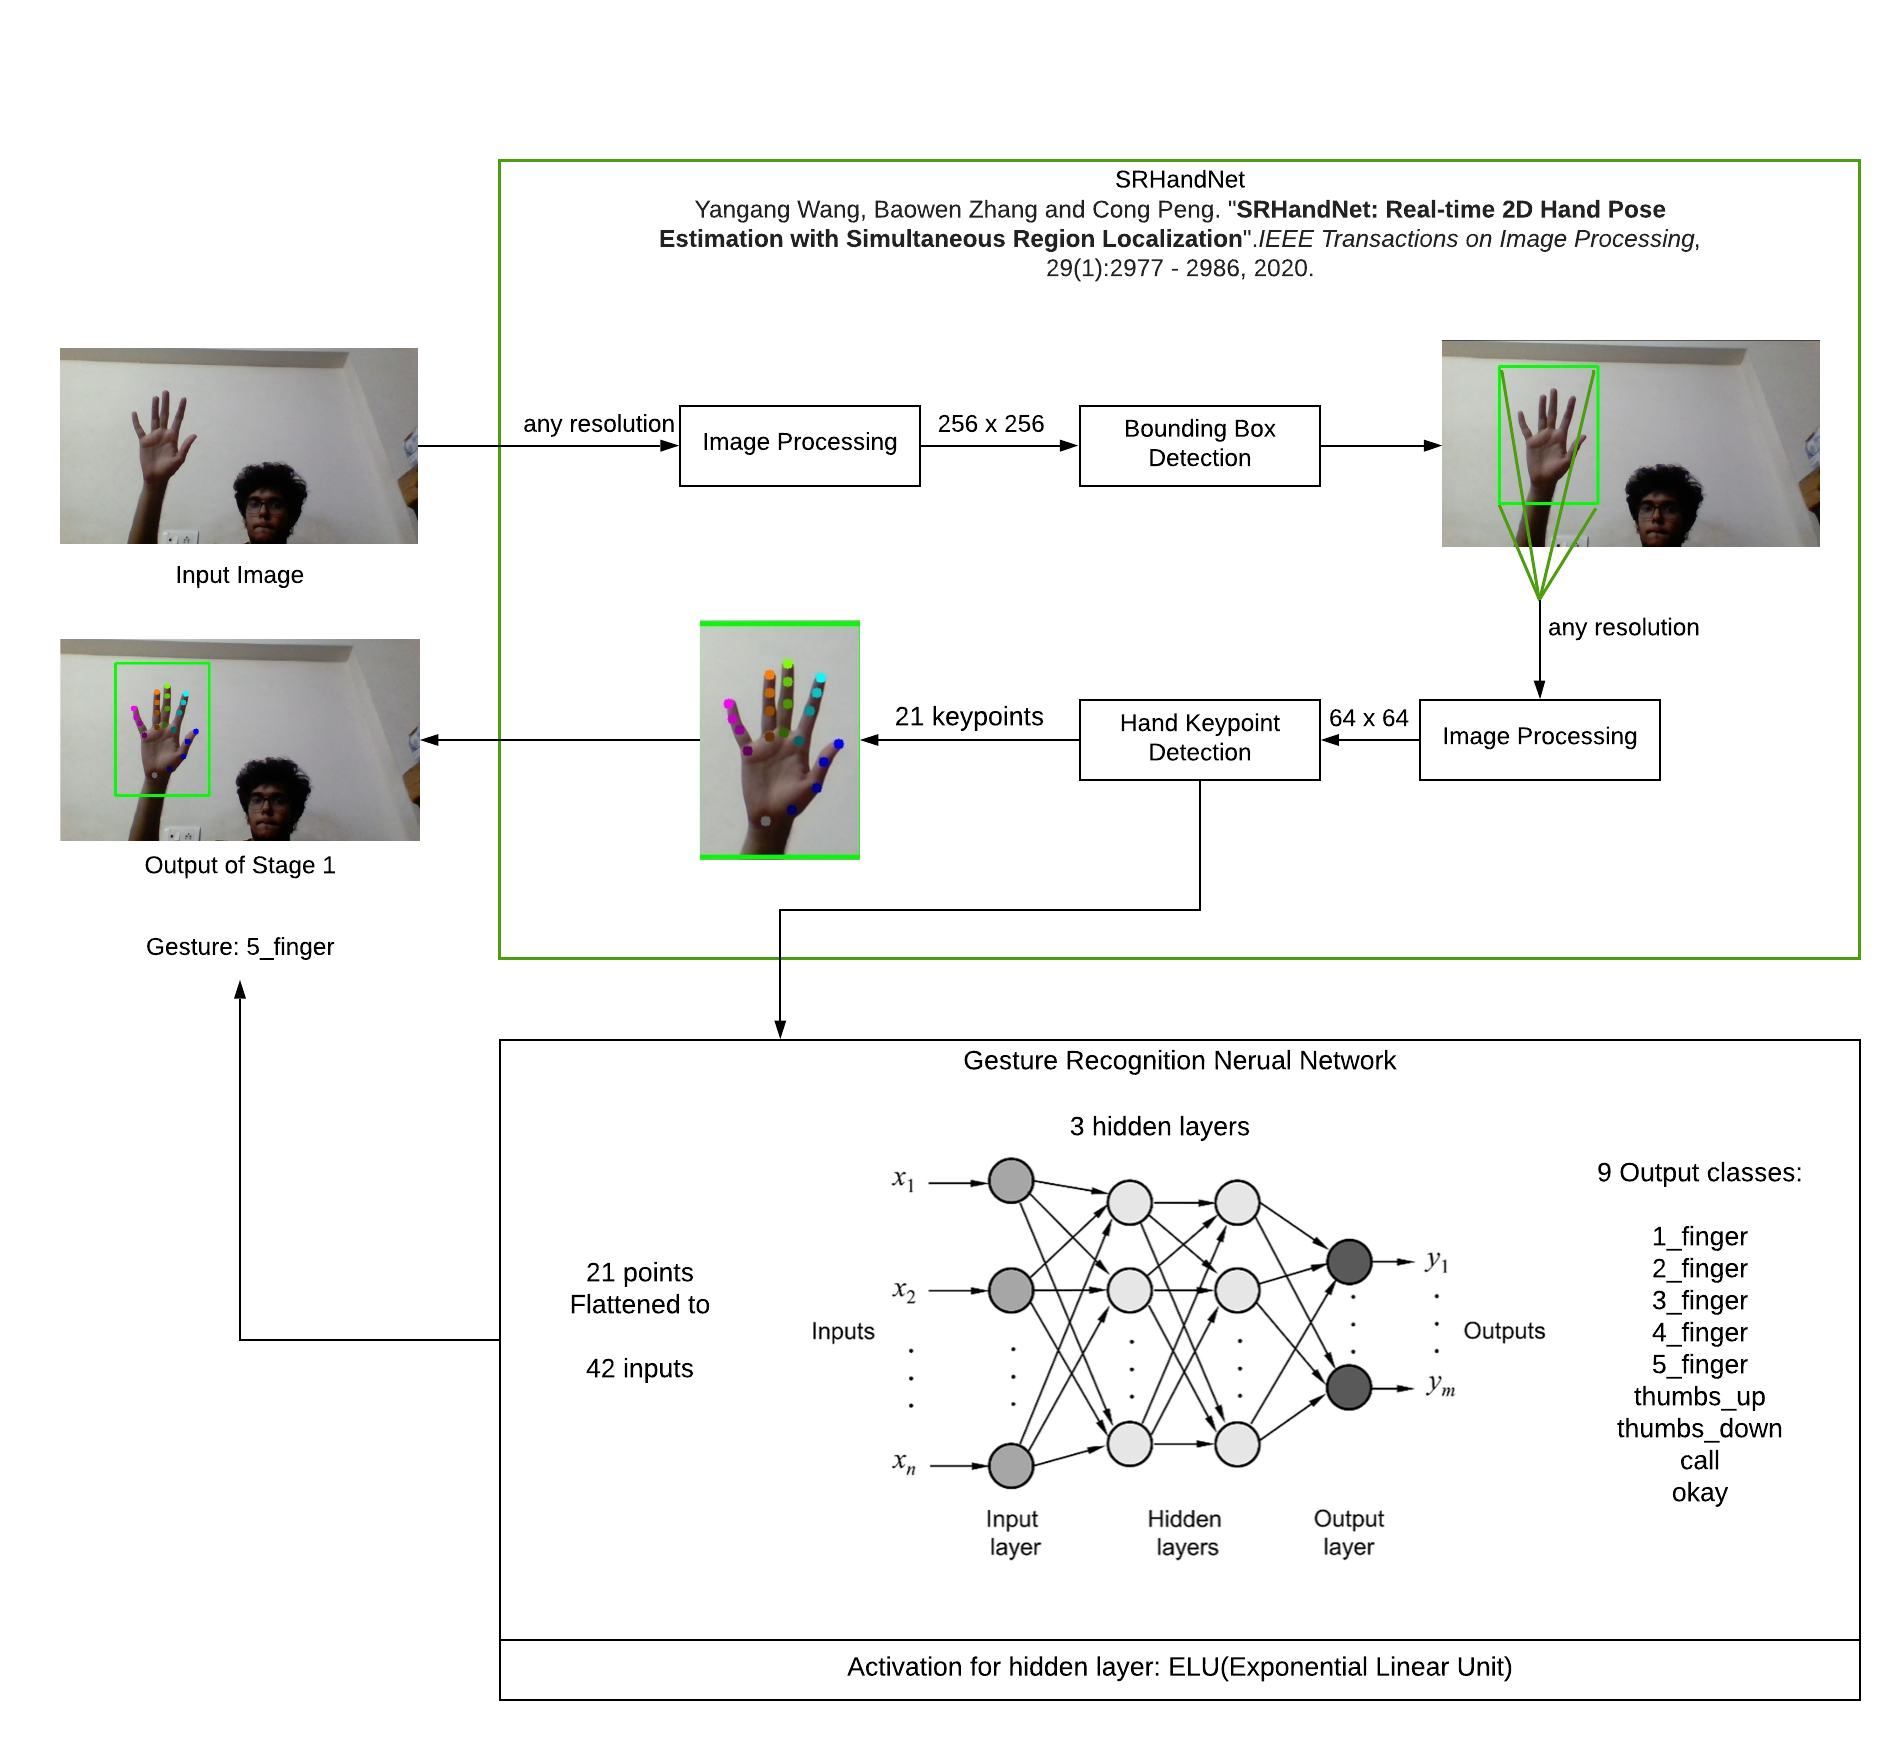

Now, to consolidate both outputs of both the stages we'll make use of `socket-io`

Socket.IO is a multi-language library for realtime web applications. It enables realtime, bi-directional communication between web clients and servers.

We shall start a socket-io server defined in sio_server.py that hosts the necessary files for the front-end and will also facilitate in the 3 way communication of Stage 1, Stage 2 and the Frontend.

We'll start the server separately and connect both the models to it.

As socket-io makes use of threads we can have two clients in the same notebook.

#### `sio1` client for Stage 1
- Receives predections from server which is the classification results made by Stage 2
- identifies itself to server as `model` on connection

#### `sio2` client for Stage 2
- Recieves data from the server which is the keypoints generated by Stage 1
- Uses that data and makes a prediction that is then sent back to the server.
- identifies itself to server as `model2` on connection



In [30]:
sio1 = socketio.Client()
sio2 = socketio.Client()

In [31]:
@sio1.event
def connect():
    print('connection established')
    sio1.emit('model')

@sio1.event
def disconnect():
    print('disconnected from server')
    
@sio1.event
def predictions(data):
    global prediction
    prediction = np.array(data['preds'])

In [32]:
@sio2.event
def connect():
    print('connection established')
    sio2.emit('model2')

@sio2.event
def disconnect():
    print('disconnected from server')
    
@sio2.event
def predict(data):
    predictions = probability_model.predict(np.array([data['m2']]))
    sio2.emit('predictions', {'preds': predictions.tolist()})

In [33]:
sio1.connect('http://127.0.0.1:8080')
sio2.connect('http://127.0.0.1:8080')

connection established
connection established


#### Open the frontend

In [34]:
import webbrowser
webbrowser.open_new_tab('http://localhost:8080/model-viewer/index.html')

True

# The Main Loop that controls the Frontend

### ie modified the main loop of Stage 1

Whenever the user keeps the same gesture for > 5 frames (except 5_finger), the mode is switched.

`mode` tells the frontend how the user wishes to interract with the 3D model.

#### Modes are mapped as follows:
- 0 - Idle
- 1 - Vertical Axis Rotation mode
- 2 - Horizontal Axis Rotation mode
- 3 - Zoom mode
- 4 - Rotation and Zoom mode
- 5 - XZ Plane movement
- 6 - Y axis movement

We maintain histories for `distances`, `centers` and `gestures`

- `distances_history` for seamless zoom actions
- `centers_history` for seamless movement and rotation actions
- `gestures_history` for seamless switching between modes

In [38]:
plt.ion()
%matplotlib qt

model_2_input = None
prediction = None
payload = {}

gestures_history = deque(maxlen=5)
centers_history = deque(maxlen=10)
distances_history = deque(maxlen=2)
mode = 0

HAND_THRESHOLD = 0.8
FINGER_THRESHOLD = 0.2

capture = cv2.VideoCapture(0)

while True:

    ret, frame = capture.read()
    
    if frame is None:
        print("Cannot open camera")
        cv2.destroyAllWindows()
        break

    t = cv2.getTickCount()

    try:
        points, rects, center  = detect_box_and_hand(model_1, frame)
    except OverflowError:
        print('overflow error')
        continue
    
    no_of_pts = len([i for i in points if i is not None])
    
    
    # if no. of points detected are enough, add input for model2 to payload
    if 21-no_of_pts < 5:
        clean_points(points)
        if 21-no_of_pts == 0:
            model2_input = np.array(points).flatten()
            payload.update({'m2': model2_input.tolist()})
        else:
            for i in range(len(points)):
                if points[i] is None:
                    points[i] = np.mean([j for j in points if j is not None], axis=0)
            model2_input = np.array(points).flatten()
            payload.update({'m2': model2_input.tolist()})
    
    # if two bounding boxes exist, add distances between their centers to distance history
    # else clear distance history
    if len(rects) == 2:
        if len(distances_history) == 2:
            distances_history.append(np.linalg.norm(
                np.mean(rects[0], axis=0) - np.mean(rects[1], axis=0)
            ))
            z = round(distances_history[-1]-distances_history[-2], 2)
            payload.update({'z': float(z)})
        else:
            distances_history.append(np.linalg.norm(
                np.mean(rects[0], axis=0) - np.mean(rects[1], axis=0)
            ))
    else:
        distances_history.clear()
    
        
    # add current center to history if it is not None, if none clear history
    if center is not None:
        centers_history.append(center)
        
        # add difference between centers to payload if current center is detected
        if len(centers_history) >= 2 and center is not None:        
            c = centers_history[-1]-centers_history[-2]
            c[0] = round(c[0], 1)
            c[1] = round(c[1], 1)

            payload.update({'x': float(c[0]), 'y': float(c[1])})

    else:
        centers_history.clear()
                     
    # add current prediction to payload for stone paper sicssors, plot prediction graph
    if prediction is not None:
        payload.update({'pred': labels[np.argmax(prediction[0])]})
        plt.cla()
        plt.bar(labels, prediction[0], 0.2)
        plt.ylim([0, 1])
        plt.draw()

    
    # change current mode based on past gesture, clear gesture history if no gesture is detected
    if prediction is not None and prediction[0].max() > 0.4:
        label = labels[np.argmax(prediction[0])]

        gestures_history.append(label)
        if len(gestures_history) == 5 and len(set(gestures_history)) == 1:
            if label == 'okay':
                mode = 0
            elif label == '5_finger':
                pass
            elif label == '1_finger':
                mode = 1
            elif label == '2_finger':
                mode = 2
            elif label == '3_finger':
                mode = 3
            elif label == '4_finger':
                mode = 4
            elif label == 'thumbs_up':
                mode = 5
            elif label == 'thumbs_down':
                mode = 6

        cv2.putText(frame, label, (frame.shape[1]-500, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
        prediction = None
    else:
        gestures_history.clear()
            
    # calculate fps
    t = (cv2.getTickCount() - t) / cv2.getTickFrequency()
    fps = 1.0 / t
    
    cv2.putText(frame, "FPS: {}".format(round(fps, 2)), (frame.shape[1] - 200, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.putText(frame, "PTS: {}".format(no_of_pts), (frame.shape[1] - 200, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    cv2.imshow('hand detection', frame)
    
    # send payload to server
    payload.update({'mode': mode})
    sio1.emit('transmit', payload)
    payload.clear()
    
    if cv2.waitKey(1) == 27:
        cv2.destroyAllWindows()
        break

capture.release()
plt.close()
cv2.destroyAllWindows()

#### Disconnect the clients from the server

In [39]:
sio1.disconnect()
sio2.disconnect()